<a href="https://colab.research.google.com/github/angadbajwa23/Brain-Image-Segmentation/blob/master/M_net%2Bregularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd gdrive/My Drive/2d

/content/gdrive/My Drive/2d


In [4]:
!pip install hdf5storage

     |████████████████████████████████| 61kB 4.5MB/s 


In [5]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt


import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Using TensorFlow backend.


In [0]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

In [0]:
images = images[..., np.newaxis]

In [0]:
masks = masks[..., np.newaxis]

In [0]:
for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.mean(images[i,:, :]))/ np.std(images[i,:, :])

In [0]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_test, images_cv, masks_test, masks_cv = train_test_split(images_test,masks_test,test_size = 0.5,train_size =0.5,random_state=1)

In [11]:
print ("number of training examples = " + str(images_train.shape[0]))
print ("number of development examples = " + str(images_cv.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))
print ("Images_val (dev) shape: " + str(images_cv.shape))
print ("Masks_val (dev) shape: " + str(masks_cv.shape))
print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

number of training examples = 2451
number of development examples = 307
number of test examples = 306
Images_train shape: (2451, 512, 512, 1)
Masks_train shape: (2451, 512, 512, 1)
Images_val (dev) shape: (307, 512, 512, 1)
Masks_val (dev) shape: (307, 512, 512, 1)
Images_test shape: (306, 512, 512, 1)
Masks_test shape: (306, 512, 512, 1)


In [0]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
def DeepModel(size_set=512):
    img_input = Input(shape=(size_set, size_set, 1))

    scale_img_2 = AveragePooling2D(pool_size=(2, 2))(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2))(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2))(scale_img_3)

    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv1')(img_input)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    input2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_input1')(scale_img_2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')(input2)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    input3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_input1')(scale_img_3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1')(input3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    input4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_input1')(scale_img_4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv1')(input4)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1')(pool4)
    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2')(conv5)

    up6 = concatenate(
        [Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5), conv4],
        axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block6_conv1')(up6)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block6_conv2')(conv6)

    up7 = concatenate(
        [Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6), conv3],
        axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block7_conv1')(up7)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block7_conv2')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7), conv2],
                      axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv1')(up8)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv2')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8), conv1],
                      axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv1')(up9)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv2')(conv9)

    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(1, (1, 1), activation='sigmoid', name='side_63')(side6)
    out7 = Conv2D(1, (1, 1), activation='sigmoid', name='side_73')(side7)
    out8 = Conv2D(1, (1, 1), activation='sigmoid', name='side_83')(side8)
    out9 = Conv2D(1, (1, 1), activation='sigmoid', name='side_93')(conv9)

    out10 = average([out6, out7, out8, out9])
    model = Model(inputs=img_input,outputs=out10)

    model.compile(optimizer = Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199),loss='binary_crossentropy', metrics=[dice_coef])
    
    model.summary()



    return model

In [0]:
filepath="cnn-parameters-improvement-{epoch:02d}-{dice_coef:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor=[dice_coef], verbose=1, save_best_only=True, mode='max'))

In [0]:
model=DeepModel()
model.fit(images_train, masks_train, batch_size=2, nb_epoch=50, verbose=1,validation_data=(images_cv,masks_cv),callbacks=[checkpoint])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 32) 9248        block1_conv1[0][0]               
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 2451 samples, validate on 307 samples
Epoch 1/50
2451/2451 [==============================] - 174s 71ms/step - loss: 0.0815 - dice_coef: 0.0496 - val_loss: 0.0588 - val_dice_coef: 0.0756
Epoch 2/50
2451/2451 [==============================] - 173s 70ms/step - loss: 0.0549 - dice_coef: 0.2014 - val_loss: 0.0453 - val_dice_coef: 0.2712
Epoch 3/50
2451/2451 [==============================] - 172s 70ms/step - loss: 0.0461 - dice_coef: 0.3082 - val_loss: 0.0394 - val_dice_coef: 0.3218
Epoch 4/50
2451/2451 [==============================] - 172s 70ms/step - loss: 0.0404 - dice_coef: 0.3809 - val_loss: 0.0439 - val_dice_coef: 0.3300
Epoch 5/50
2451/2451 [==============================] - 172s 70ms/step - loss: 0.0360 - dice_coef: 0.4341 - val_loss: 0.0356 - val_dice_coef: 0.4657
Epoch 6/50
2451/2451 [==============================] - 172s 70ms/step - loss: 0.0323 - dice_coef: 0.4817 - val_loss: 0.0387 - val_dice_coef: 0.4547
Epoch 7/50
2451/2451 [==============================] - 173

In [0]:
model.save('M_net_regularization.h5')

In [0]:
print('saved')

saved


In [0]:
from datetime import datetime
import tensorflow as tf
from tensorflow import keras

In [0]:
dependencies = {
     'dice_coef': dice_coef
}
model = keras.models.load_model('M_net_regularization.h5', custom_objects=dependencies)

In [16]:
results = model.evaluate(images_test, masks_test, batch_size=2)
print('dice_coeff:', results)

153/153 [==============================] - 11s 74ms/step - loss: 0.0765 - dice_coef: 0.6455
dice_coeff: [0.07649721205234528, 0.6455184817314148]


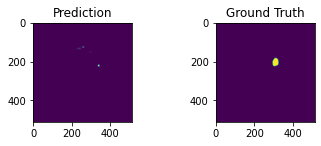

In [17]:
predictions = model.predict(images_test[0:1,:])
plt.subplot(221)
plt.title('Prediction')
plt.imshow(predictions[0,:,:,0])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(masks_test[0,:,:,0])

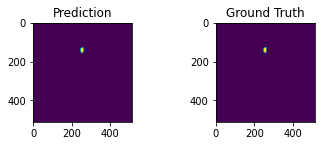

In [18]:
predictions = model.predict(images_train[0:1,:])
plt.subplot(221)
plt.title('Prediction')
plt.imshow(predictions[0,:,:,0])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(masks_train[0,:,:,0])